In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Perceptron(object):
    """Perceptron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [4]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training samples in each epoch.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [5]:
cols = ['ID','diagnostico']
for i in range(0,30):
    cols.append('entrada')
df = pd.read_csv('wdbc.csv',names=cols)

/home/michel/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


### Analisando os dados

In [6]:
df.head()

,ID,diagnostico,entrada,entrada.1,entrada.2,entrada.3,entrada.4,entrada.5,entrada.6,entrada.7,...,entrada.20,entrada.21,entrada.22,entrada.23,entrada.24,entrada.25,entrada.26,entrada.27,entrada.28,entrada.29
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID             569 non-null int64
diagnostico    569 non-null object
entrada        569 non-null float64
entrada.1      569 non-null float64
entrada.2      569 non-null float64
entrada.3      569 non-null float64
entrada.4      569 non-null float64
entrada.5      569 non-null float64
entrada.6      569 non-null float64
entrada.7      569 non-null float64
entrada.8      569 non-null float64
entrada.9      569 non-null float64
entrada.10     569 non-null float64
entrada.11     569 non-null float64
entrada.12     569 non-null float64
entrada.13     569 non-null float64
entrada.14     569 non-null float64
entrada.15     569 non-null float64
entrada.16     569 non-null float64
entrada.17     569 non-null float64
entrada.18     569 non-null float64
entrada.19     569 non-null float64
entrada.20     569 non-null float64
entrada.21     569 non-null float64
entrada.22     569 non-null float6

In [8]:
df.describe()

,ID,entrada,entrada.1,entrada.2,entrada.3,entrada.4,entrada.5,entrada.6,entrada.7,entrada.8,...,entrada.20,entrada.21,entrada.22,entrada.23,entrada.24,entrada.25,entrada.26,entrada.27,entrada.28,entrada.29
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


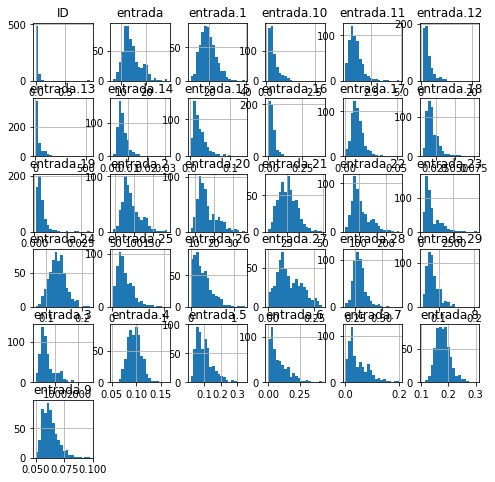

In [9]:
df.hist(bins=20, figsize=(8,8));

In [10]:
df.corr().style.set_precision(4)

,ID,entrada,entrada.1,entrada.2,entrada.3,entrada.4,entrada.5,entrada.6,entrada.7,entrada.8,entrada.9,entrada.10,entrada.11,entrada.12,entrada.13,entrada.14,entrada.15,entrada.16,entrada.17,entrada.18,entrada.19,entrada.20,entrada.21,entrada.22,entrada.23,entrada.24,entrada.25,entrada.26,entrada.27,entrada.28,entrada.29
ID,1,0.07463,0.09977,0.07316,0.09689,-0.01297,9.57e-05,0.05008,0.04416,-0.02211,-0.05251,0.143,-0.007526,0.1373,0.1777,0.09678,0.03396,0.05524,0.07877,-0.01731,0.02573,0.08241,0.06472,0.07999,0.1072,0.01034,-0.002968,0.0232,0.03517,-0.04422,-0.02987
entrada,0.07463,1,0.3238,0.9979,0.9874,0.1706,0.5061,0.6768,0.8225,0.1477,-0.3116,0.6791,-0.09732,0.6742,0.7359,-0.2226,0.206,0.1942,0.3762,-0.1043,-0.04264,0.9695,0.297,0.9651,0.9411,0.1196,0.4135,0.5269,0.7442,0.164,0.007066
entrada.1,0.09977,0.3238,1,0.3295,0.3211,-0.02339,0.2367,0.3024,0.2935,0.0714,-0.07644,0.2759,0.3864,0.2817,0.2598,0.006614,0.192,0.1433,0.1639,0.009127,0.05446,0.3526,0.912,0.358,0.3435,0.0775,0.2778,0.301,0.2953,0.105,0.1192
entrada.2,0.07316,0.9979,0.3295,1,0.9865,0.2073,0.5569,0.7161,0.851,0.183,-0.2615,0.6918,-0.08676,0.6931,0.745,-0.2027,0.2507,0.2281,0.4072,-0.08163,-0.005523,0.9695,0.303,0.9704,0.9415,0.1505,0.4558,0.5639,0.7712,0.1891,0.05102
entrada.3,0.09689,0.9874,0.3211,0.9865,1,0.177,0.4985,0.686,0.8233,0.1513,-0.2831,0.7326,-0.06628,0.7266,0.8001,-0.1668,0.2126,0.2077,0.3723,-0.0725,-0.01989,0.9627,0.2875,0.9591,0.9592,0.1235,0.3904,0.5126,0.722,0.1436,0.003738
entrada.4,-0.01297,0.1706,-0.02339,0.2073,0.177,1,0.6591,0.522,0.5537,0.5578,0.5848,0.3015,0.06841,0.2961,0.2466,0.3324,0.3189,0.2484,0.3807,0.2008,0.2836,0.2131,0.03607,0.2389,0.2067,0.8053,0.4725,0.4349,0.5031,0.3943,0.4993
entrada.5,9.57e-05,0.5061,0.2367,0.5569,0.4985,0.6591,1,0.8831,0.8311,0.6026,0.5654,0.4975,0.0462,0.5489,0.4557,0.1353,0.7387,0.5705,0.6423,0.23,0.5073,0.5353,0.2481,0.5902,0.5096,0.5655,0.8658,0.8163,0.8156,0.5102,0.6874
entrada.6,0.05008,0.6768,0.3024,0.7161,0.686,0.522,0.8831,1,0.9214,0.5007,0.3368,0.6319,0.07622,0.6604,0.6174,0.09856,0.6703,0.6913,0.6833,0.178,0.4493,0.6882,0.2999,0.7296,0.676,0.4488,0.755,0.8841,0.8613,0.4095,0.5149
entrada.7,0.04416,0.8225,0.2935,0.851,0.8233,0.5537,0.8311,0.9214,1,0.4625,0.1669,0.698,0.02148,0.7106,0.6903,0.02765,0.4904,0.4392,0.6156,0.09535,0.2576,0.8303,0.2928,0.8559,0.8096,0.4528,0.6675,0.7524,0.9102,0.3757,0.3687
entrada.8,-0.02211,0.1477,0.0714,0.183,0.1513,0.5578,0.6026,0.5007,0.4625,1,0.4799,0.3034,0.1281,0.3139,0.224,0.1873,0.4217,0.3426,0.3933,0.4491,0.3318,0.1857,0.09065,0.2192,0.1772,0.4267,0.4732,0.4337,0.4303,0.6998,0.4384


In [11]:
df['diagnostico'].value_counts()

B    357
M    212
Name: diagnostico, dtype: int64

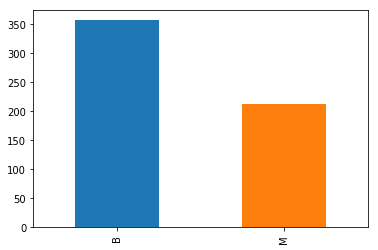

In [12]:
df['diagnostico'].value_counts().plot(kind='bar');

### Codficando os diagnosticos para Benigno = 1 e Maligno = -1

In [13]:
df['diagnostico'] = np.where(df['diagnostico'] == 'B', 1, -1)

In [14]:
df.head()

,ID,diagnostico,entrada,entrada.1,entrada.2,entrada.3,entrada.4,entrada.5,entrada.6,entrada.7,...,entrada.20,entrada.21,entrada.22,entrada.23,entrada.24,entrada.25,entrada.26,entrada.27,entrada.28,entrada.29
0,842302,-1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,-1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,-1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,-1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,-1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
df['diagnostico'].value_counts()

 1    357
-1    212
Name: diagnostico, dtype: int64

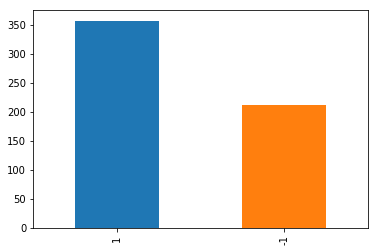

In [16]:
df['diagnostico'].value_counts().plot(kind='bar');

### Separação entre features (X) e label (y)

In [17]:
X = df.values[:,2:]
y = df.values[:,1]

### Randomização dos dados usando semente (seed)

In [18]:
rs = np.random.RandomState(1)
shuffled_indices = rs.permutation(X.shape[0])
shuffled_indices

array([421,  47, 292, 186, 414, 132, 161, 197, 245, 453, 411, 214, 283,
       107, 542, 518, 324, 488, 376, 237, 362, 420, 451, 519,  65, 242,
       558,  85, 180, 207, 564, 342,  17, 435,  66, 326, 274,  90,  41,
       187, 520,  49, 160, 124, 221, 257, 539, 273, 486,  29, 492,   0,
       111, 285, 424, 477, 195, 277, 378, 547, 159,   9, 147,  92, 246,
       286, 480, 233, 189, 399, 179,  69,  40, 432, 358, 258,  38, 135,
       304,  34,  67, 335, 308, 370, 403, 120, 501, 545,  62, 344, 457,
        31, 555, 443, 400,   5,  59, 496, 289, 346, 531, 305, 425, 347,
       462, 165, 550, 295, 119, 172,   3,  68, 448, 442, 408,   4, 307,
       386, 404, 434,  19, 517, 535, 445, 554, 236, 117, 157, 162,  78,
       409, 484, 334,  42, 173, 223, 201, 133, 232, 413, 514, 244, 415,
       562, 291,  16, 546, 293, 350, 392, 102, 551, 225, 146, 447, 306,
       128, 247, 483, 110, 439, 284, 410, 329, 142, 407,   6, 487,  11,
       268, 419, 249,  58, 476, 529, 422, 192, 527, 472, 101, 54

In [19]:
X = X[shuffled_indices]
y = y[shuffled_indices]

In [20]:
X[:5]

array([[1.469e+01, 1.398e+01, 9.822e+01, 6.561e+02, 1.031e-01, 1.836e-01,
        1.450e-01, 6.300e-02, 2.086e-01, 7.406e-02, 5.462e-01, 1.511e+00,
        4.795e+00, 4.945e+01, 9.976e-03, 5.244e-02, 5.278e-02, 1.580e-02,
        2.653e-02, 5.444e-03, 1.646e+01, 1.834e+01, 1.141e+02, 8.092e+02,
        1.312e-01, 3.635e-01, 3.219e-01, 1.108e-01, 2.827e-01, 9.208e-02],
       [1.317e+01, 1.866e+01, 8.598e+01, 5.346e+02, 1.158e-01, 1.231e-01,
        1.226e-01, 7.340e-02, 2.128e-01, 6.777e-02, 2.871e-01, 8.937e-01,
        1.897e+00, 2.425e+01, 6.532e-03, 2.336e-02, 2.905e-02, 1.215e-02,
        1.743e-02, 3.643e-03, 1.567e+01, 2.795e+01, 1.028e+02, 7.594e+02,
        1.786e-01, 4.166e-01, 5.006e-01, 2.088e-01, 3.900e-01, 1.179e-01],
       [1.295e+01, 1.602e+01, 8.314e+01, 5.137e+02, 1.005e-01, 7.943e-02,
        6.155e-02, 3.370e-02, 1.730e-01, 6.470e-02, 2.094e-01, 7.636e-01,
        1.231e+00, 1.767e+01, 8.725e-03, 2.003e-02, 2.335e-02, 1.132e-02,
        2.625e-02, 4.726e-03, 1.374e

In [21]:
y[:5]

array([ 1., -1.,  1., -1., -1.])

### Selecionando 70% dos dados para treino e 30% para teste

In [22]:
n = int(np.count_nonzero(y) * 0.70)
X_train = X[:n]
y_train = y[:n]
X_test = X[n:]
y_test = y[n:]

### Calculando médias de matrizes e vetores para verificação/checagem

In [23]:
np.average(X_train), np.average(y_train)

(62.11875541613904, 0.25125628140703515)

In [24]:
np.average(X_test), np.average(y_test)

(61.35994541265107, 0.2631578947368421)

## Criação, treino e avaliação de modelos usando a métrica acurácia

### Perceptron

In [25]:
modelP = Perceptron(eta=0.0001, n_iter=50)
modelP.fit(X_train, y_train)
y_pred = modelP.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

0.935672514619883

In [26]:
modelP.errors_

[165,
 100,
 101,
 89,
 89,
 79,
 81,
 80,
 77,
 71,
 66,
 78,
 64,
 65,
 71,
 64,
 58,
 61,
 57,
 55,
 55,
 62,
 58,
 53,
 60,
 58,
 57,
 58,
 63,
 56,
 65,
 60,
 60,
 59,
 56,
 56,
 47,
 54,
 56,
 55,
 50,
 56,
 55,
 50,
 56,
 54,
 56,
 48,
 52,
 56]

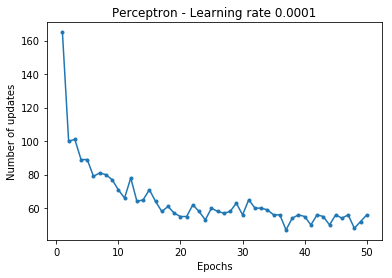

In [27]:
plt.plot(range(1, len(modelP.errors_)+1), modelP.errors_, marker='.')
plt.xlabel('Epochs')
plt.ylabel('Number of updates');
plt.title('Perceptron - Learning rate 0.0001');

In [28]:
modelAGD = AdalineGD(eta=0.0001, n_iter=30)
modelAGD.fit(X_train, y_train)
y_pred = modelAGD.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

0.631578947368421

In [29]:
modelAGD.cost_

[52675.170965794125,
 226497365409235.6,
 9.783225871235874e+23,
 4.225723009873368e+33,
 1.8252399761834e+43,
 7.883860259827619e+52,
 3.405319487164456e+62,
 1.4708785325319238e+72,
 6.353247222817128e+81,
 2.7441933090662974e+91,
 1.1853146357155366e+101,
 5.1197952454723154e+110,
 2.2114215555718146e+120,
 9.551915773921768e+129,
 4.1258119566670987e+139,
 1.7820848408494987e+149,
 7.697457890327778e+158,
 3.3248056778893403e+168,
 1.436101756349391e+178,
 6.203033964676854e+187,
 2.6793108633712588e+197,
 1.1572896010981648e+207,
 4.998745159136716e+216,
 2.1591357204179377e+226,
 9.326074666286431e+235,
 4.0282631544956304e+245,
 1.739950045706476e+255,
 7.515462732804071e+264,
 3.2461955001261672e+274,
 1.4021472262836524e+284]

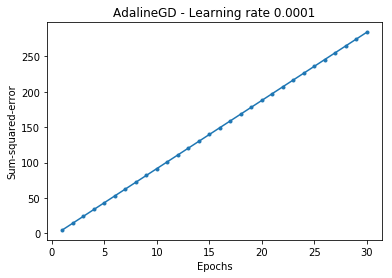

In [30]:
plt.plot(range(1, len(modelAGD.cost_)+1), np.log10(modelAGD.cost_), marker='.')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error');
plt.title('AdalineGD - Learning rate 0.0001');

In [42]:
modelASGD = AdalineSGD(eta=0.00001, n_iter=50)
modelASGD.fit(X_train, y_train)
y_pred = modelASGD.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

/home/michel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: overflow encountered in double_scalars
/home/michel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in add
/home/michel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in greater_equal


0.3684210526315789

In [47]:
modelASGD = AdalineSGD(eta=0.000001, n_iter=50)
modelASGD.fit(X_train, y_train)
y_pred = modelASGD.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

0.6374269005847953

#### Ao usar um eta <= 0.00001 ocorre um aviso em tempo de execucao de overflow e valor invalido encontrado em add e greater_equal

In [48]:
modelASGD = AdalineSGD(eta=0.000001, n_iter=50)
modelASGD.fit(X_train, y_train)
y_pred = modelASGD.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

0.43859649122807015

In [32]:
#row = np.count_nonzero(df.values[:,1])

In [33]:
row = 397

In [36]:
it = 0;
end = 20;
acuracys = []
modelASGD = AdalineSGD(eta=0.000001, n_iter=29)
#modelASGD.fit(X_train[it:end],y_train[it:end])
#acuracys.append(sum(y_pred == y_test) / y_test.shape[0])
it = end
end += 20
for i in range(0,20):
    print("Loop: ",i, " it: ",it, " end: ",end)
    modelASGD.partial_fit(X_train[it:end],y_train[it:end])
    acuracys.append(sum(y_pred == y_test) / y_test.shape[0])
    if(end > row): 
        end = row;
    else:
        it = end;
        end += 20;

Loop:  0  it:  20  end:  40
Loop:  1  it:  40  end:  60
Loop:  2  it:  60  end:  80
Loop:  3  it:  80  end:  100
Loop:  4  it:  100  end:  120
Loop:  5  it:  120  end:  140
Loop:  6  it:  140  end:  160
Loop:  7  it:  160  end:  180
Loop:  8  it:  180  end:  200
Loop:  9  it:  200  end:  220
Loop:  10  it:  220  end:  240
Loop:  11  it:  240  end:  260
Loop:  12  it:  260  end:  280
Loop:  13  it:  280  end:  300
Loop:  14  it:  300  end:  320
Loop:  15  it:  320  end:  340
Loop:  16  it:  340  end:  360
Loop:  17  it:  360  end:  380
Loop:  18  it:  380  end:  400
Loop:  19  it:  380  end:  397


In [37]:
acuracys

[0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789]